In [1]:
__author__ = 'David Nidever <dnidever@noao.edu>, Knut Olsen <kolsen@noao.edu>, Robert Nikutta <rnikutta@noao.edu>, Stephanie Juneau <sjuneau@noao.edu>' # single string; emails in <>
__version__ = '20190101' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['nsc_dr1']  # enter used datasets by hand
__keywords__ = ['science example','dwarf galaxies'], # keywords relevant to this notebook, e.g. ['science case','dwarf galaxies'] 

# Detecting dwarf galaxies in NSC DR1

*David Nidever, Knut Olsen, Robert Nikutta, Stéphanie Juneau & NOAO Data Lab Team*

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & Attribution](#attribution)
* [Imports & setup](#import)
* [Authentication](#auth)
* [Preface](#preface)
* [Chapter 1 - Photometry containing dwarfs](#chapter1)
* [Chapter 2 - Filtering and plotting the dwarfs](#chapter2)
* [Chapter 3 - Retrieve Images](#chapter3)
* [Resources](#resources)

<a class="anchor" id="goals"></a>
# Goals
In this notebook, we demonstrate the discovery of classical and faint Milky Way dwarf companions in NSC DR1.  We query the database around the positions of known dwarfs and apply filtering techniques to reveal the dwarfs as spatial overdensities of filtered sources.

# Summary

**Background**
Ultrafaint dwarf galaxies are crucial to understanding many aspects of the universe. For instance, they are dominated by dark matter; their localization in space can thus trace the large-scale structure of the dark matter distribution. 

**Data retrieval**
We will retrieve data from the NSC DR1 catalog ([Nidever et al. (2018, AJ, 156, 131)](http://adsabs.harvard.edu/abs/2018AJ....156..131N)) and look for overdensities of blue objects.

The required columns are RA, Dec, and the g, r, i magnitudes.

**Detection**
We will convolve the spatial distribution of our dataset with a pair of Gaussian kernels and subtract the results, as done in e.g. [Stanford et al. (2005, ApJ, 634, 2, L129)](http://adsabs.harvard.edu/abs/2005ApJ...634L.129S) (galaxy clusters), or [Koposov et al. (2008, ApJ, 686, 279)](http://adsabs.harvard.edu/abs/2008ApJ...686..279K) (MW satellites). This has the effect of convolving the spatial distribution with a Mexican hat filter, which is useful for detecting objects at a desired spatial scale.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: http://datalab.noao.edu/disclaimers.php

<a class="anchor" id="import"></a>
# Imports and setup

In [2]:
# Python 2/3 compatibility
from __future__ import print_function # to use print() as a function in Python 2

try:
    input = raw_input # use 'input' function in both Python 2 and 3
except NameError:
    pass

# std lib
from getpass import getpass

# 3rd party
import pandas as pd
import numpy as np
import pylab as plt
import matplotlib
from astropy import utils, io, convolution, stats, wcs
from astropy.visualization import make_lupton_rgb
from astropy import units as u
from astropy.stats import median_absolute_deviation as mad
%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc, helpers

#Simple Image Access (SIA) service
from pyvo.dal import sia
DEF_ACCESS_URL = "http://datalab.noao.edu/sia"
svc = sia.SIAService(DEF_ACCESS_URL)

# Quiet the Astropy warnings
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

<a class="anchor" id="auth"></a>
# Authentication
First, obtain a Data Lab authentication token, which needs to passed along to all Data Lab server-side operations.

In [4]:
# Authenticated users please uncomment the next line
token = ac.login(raw_input("Enter user name: "),getpass("Enter password: "))

Enter user name: dnidever
Enter password: ········


<a class="anchor" id="preface"></a>
# Preface
We're going to select the database and define some functions that we'll use later.


In [5]:
#The NSC DR1 schema
try:
    print(qc.schema('nsc_dr1',format='json',profile='default'))
except Exception as e:
    print(e.message)



Schema: nsc_dr1

      Table Name   Description
      ----------   -----------
            chip   CCD information table
        coverage   Survey coverage table
        exposure   Exposures contributing to the catalog
            meas   Primary measurements table
     nsc_allwise   NSC vs ALLWISE 1-arcsec crossmatch
         nsc_des   NSC vs DES 1-arcsec crossmatch
       nsc_lsdr4   NSC vs DECaLS DR4 1-arcsec crossmatch
       nsc_lsdr5   NSC vs DECaLS DR5 1-arcsec crossmatch
          object   Primary object table



In [6]:
# A function to retrieve data from a point on the sky
def getData (ra,dec,radius=1.0,columns='*'):

    query_template = \
    """SELECT {0:s} FROM nsc_dr1.object
       WHERE q3c_radial_query(ra,dec,{1:f},{2:f},{3:f})"""

    query = query_template.format(columns,ra,dec,radius)
    print(query)
    
    try:
        result = qc.query(token,sql=query) # by default the result is a CSV formatted string
    except Exception as e:
        print(e.message)
        
    df = helpers.utils.convert(result,'pandas')
    
    return df

In [7]:
# A Mexican-hat convolution filter
def dwarf_filter (ra,dec,fwhm_small=2.0,fwhm_big=20):

    # Based on Koposov et al. (2008).
    # Code by Ken Mighell and Mike Fitzpatrick.
    # Minor edits by Rorbert Nikutta.
    
    x, y = ra, dec

    # Information about declination (y) [degrees]
    ymean = (y.min() + y.max()) / 2.0
    ydiff_arcmin = (y.max() - y.min()) * 60.0 # convert from degrees to arcmin

    # Information about right ascension (x) [degrees in time]:
    xdiff = x.max() - x.min() # angular separation [degrees (time)] 
    xmean = (x.min() + x.max())/2.0

    # convert from degrees in time to separation in angular degrees:
    xdiff_angular = (x.max() - x.min()) * np.cos(ymean*(np.pi/180.0))

    # convert from degress to arcmin
    xdiff_angular_arcmin = xdiff_angular * 60.0 

    # Get the number of one-arcmin pixels in the X and Y directions:
    nx = np.rint (xdiff_angular_arcmin).astype('int')
    ny = np.rint (ydiff_arcmin).astype('int')
    
    # Create a two-dimensional histogram of the raw counts:
    Counts, xedges, yedges  = np.histogram2d (x, y, (nx,ny) )
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    raw_hist = np.rot90(Counts).copy() # hack around Pythonic weirdness

    # Make the small and big Gaussian kernels with a standard deviation
    # of the given FWHM in arcmin^2 pixels.
    kernel_small = convolution.Gaussian2DKernel(fwhm_small/2.35,factor=1)
    kernel_big = convolution.Gaussian2DKernel(fwhm_big/2.35,factor=1)

    # Compute the differential convolution kernels.
    conv_big = convolution.convolve (raw_hist, kernel_big)
    conv_small = convolution.convolve (raw_hist, kernel_small)
    conv_delta = conv_small - conv_big
    delta = conv_delta.copy()

    # Compute statistics and the floor
    mean = np.mean (delta, dtype='float64')
    sigma = np.std (delta, dtype='float64')
    sigmaRaw = np.std(raw_hist,dtype='float64')
    median = np.median (delta)                       # not used
    floor = mean 

    # Clip to specified limits.
    clipped = delta.copy()
    clipped[ delta < floor ] = floor

    # Return the computed fields.
    return raw_hist, extent, delta, clipped, sigma

In [8]:
# A little function to download the deepest stacked images
#   adapted from R. Nikutta
def download_deepest_image(ra,dec,fov=0.1,band='g'):
    imgTable = svc.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).votable.to_table()
    print("The full image list contains", len(imgTable), "entries")
    
    sel0 = imgTable['obs_bandpass'].astype(str)==band
    sel = sel0 & ((imgTable['proctype'].astype(str)=='Stack') & (imgTable['prodtype'].astype(str)=='image')) # basic selection
    Table = imgTable[sel] # select
    if (len(Table)>0):
        row = Table[np.argmax(Table['exptime'].data.data.astype('float'))] # pick image with longest exposure time
        url = row['access_url'].decode() # get the download URL
        print ('downloading deepest image...')
        image = io.fits.getdata(utils.data.download_file(url,cache=True,show_progress=False,timeout=120))

    else:
        print ('No image available.')
        image=None
        
    return image

In [9]:
# Multi panel image plotter
def plot_images(images,geo=None,panelsize=4,bands=list('gri'),cmap=matplotlib.cm.gray_r):
    n = len(images)
    if geo is None: geo = (n,1)
        
    fig = plt.figure(figsize=(geo[0]*panelsize,geo[1]*panelsize))
    for j,img in enumerate(images):
        ax = fig.add_subplot(geo[1],geo[0],j+1)
        if img is not None:
            print(img.min(),img.max())
            vmin = np.median(img)-2*np.std(img)
            vmax = np.median(img)+2*np.std(img)
            ax.imshow(img,origin='lower',interpolation='none',cmap=cmap,norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))
            ax.set_title('%s band' % bands[j])
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)

<a class="anchor" id="chapter1"></a>
# Chapter 1 - Photometry containing dwarfs
We take the positions of the first eight dwarf galaxies and query the database around them.

In [10]:
# Locations of Dwarfs from McConnachie et al. (2012), Bechtol et al. (2015) and others
ra = [86.4,260.1,185.43,56.09]
dec = [34.7,-22.2,-31.99,-43.53]
name = ['Draco','Carina','Hya II','Eri II']
radius = 0.85 # degrees
columns = '''ra,dec,gmag,gerr,imag,rmag,zmag,class_star,fwhm'''
df_dict = {dwarf: pd.DataFrame() for dwarf in name}

In [11]:
from astropy.coordinates import name_resolve

In [12]:
def resolve_coordinates(name):
    try:
        coords = name_resolve.get_icrs_coordinates(name)
    except Exception as e:
        raise

    ra = coords.ra.to('deg').value
    dec = coords.dec.to('deg').value      

    return coords, ra, dec        

In [13]:
%%time
for j,name_ in enumerate(name):
    print(name_)
    coords, ra_, dec_ = resolve_coordinates(name_)
    print(coords,ra_,dec_)
    df = getData(ra_,dec_,radius=radius,columns=columns)
    df_dict[name_] = df
    print(str(len(df))+' objects found')

Draco
<SkyCoord (ICRS): (ra, dec) in deg
    (260.051625, 57.915361)> 260.051625 57.915361
SELECT ra,dec,gmag,gerr,imag,rmag,zmag,class_star,fwhm FROM nsc_dr1.object
       WHERE q3c_radial_query(ra,dec,260.051625,57.915361,0.850000)
74870 objects found
Carina
<SkyCoord (ICRS): (ra, dec) in deg
    (100.402888, -50.966196)> 100.402888 -50.966196
SELECT ra,dec,gmag,gerr,imag,rmag,zmag,class_star,fwhm FROM nsc_dr1.object
       WHERE q3c_radial_query(ra,dec,100.402888,-50.966196,0.850000)
429762 objects found
Hya II
<SkyCoord (ICRS): (ra, dec) in deg
    (185.42542, -31.98528)> 185.42542 -31.98528
SELECT ra,dec,gmag,gerr,imag,rmag,zmag,class_star,fwhm FROM nsc_dr1.object
       WHERE q3c_radial_query(ra,dec,185.425420,-31.985280,0.850000)
304486 objects found
Eri II
<SkyCoord (ICRS): (ra, dec) in deg
    (56.0878, -43.5332)> 56.0878 -43.5332
SELECT ra,dec,gmag,gerr,imag,rmag,zmag,class_star,fwhm FROM nsc_dr1.object
       WHERE q3c_radial_query(ra,dec,56.087800,-43.533200,0.850000)
14168

<a class="anchor" id="chapter2"></a>
# Chapter 2 - Filtering and plotting the dwarfs
We filter the photometry to include objects with S/N>10, that are point-like (CLASS_STAR, and FWHM), and that are relatively blue (*g-i* < 1.0).  We convolve the result with the spatial filter defined above.

In [14]:
# Create a WCS for a tangent plane projection in our region
def get_wcs(ra,dec,image,fov=1.,unit='deg',projection=("RA---TAN","DEC--TAN")):
    npix = image.shape[0]
    crpix = npix/2 + 1
    cdelt = fov/float(npix)
    w = wcs.WCS(naxis=2)
    w.wcs.cunit = (unit,unit)
    w.wcs.crpix = (crpix,crpix)
    w.wcs.cdelt = np.array((-cdelt,cdelt))
    w.wcs.ctype = projection
    w.wcs.crval = (ra,dec) #coords.ra.to(unit).value, coords.dec.to(unit).value)
    return w

Eri II
Draco
Hya II
Carina


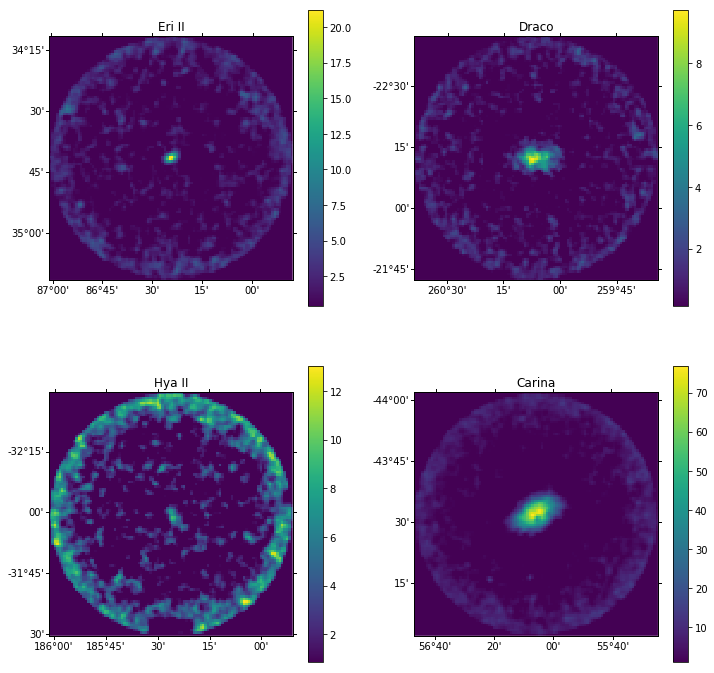

In [15]:
# Loop over the dwarfs, filter then and plot a density map
nrow, ncol = 2, 2
fig = plt.figure(figsize=(6*ncol,6*nrow))
for j,name_ in enumerate(df_dict):
    print(name_)
    df = df_dict[name_]
    keep = (df['gmag']<90) & (df['rmag']<90) & \
           1.087/df['gerr']>10 & \
           ((df['gmag']-df['rmag'])<1.0) & (df['gmag']>18) & ((df['gmag']-df['rmag'])>(-0.5)) & \
           (np.abs(df['class_star'])>0.8) & (df['fwhm']<2) 
    df2 = df[keep]
    raw_hist, extent, delta, clipped, sigma = dwarf_filter(df2['ra'],df2['dec'])
    #skyPlot(df2,ax)
    w = get_wcs(ra[j],dec[j],clipped,fov=1.)
    ax = fig.add_subplot(nrow,ncol,j+1,projection=w)
    im = plt.imshow(clipped)
    plt.colorbar()
    ax.set_title(name_)

<a class="anchor" id="chapter3"></a>
# Chapter 3 - Retrieve images
We demonstrate how to retrieve images though the SIA (Simple Image Access) service.

In [16]:
# Get g, r and i stacked image for the third galaxy
rac = ra[2]
decc = dec[2]
band = 'g'
gimage = download_deepest_image(rac, decc, fov=0.1, band=band) # FOV in deg
band = 'r'
rimage = download_deepest_image(rac, decc, fov=0.1, band=band) # FOV in deg
band = 'i'
iimage = download_deepest_image(rac, decc, fov=0.1, band=band) # FOV in deg
images=[gimage,rimage,iimage]

The full image list contains 3157 entries
downloading deepest image...
The full image list contains 3157 entries
downloading deepest image...
The full image list contains 3157 entries
downloading deepest image...


2304.0452 39016.523
3063.2227 39893.363
2365.7983 39021.27


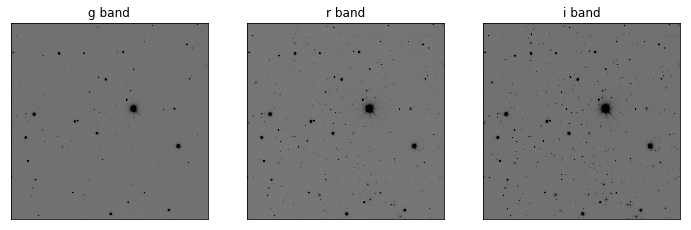

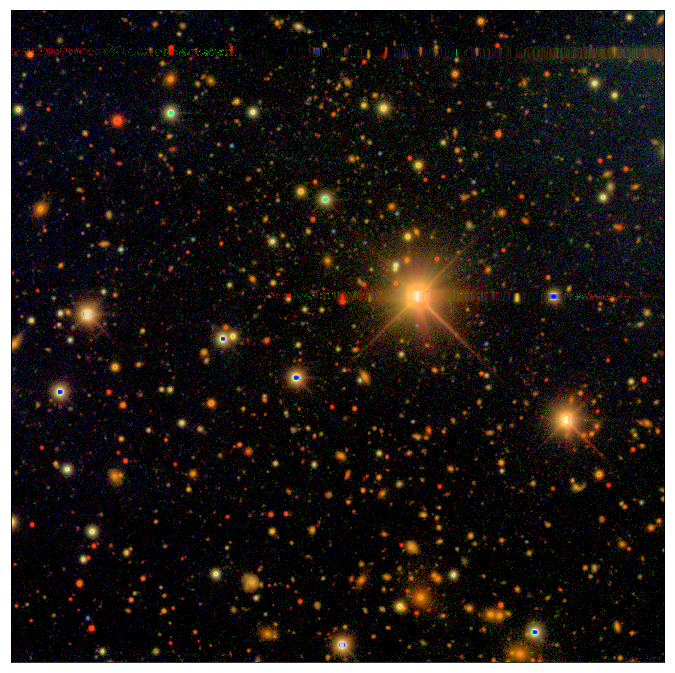

In [17]:
# Now plot the image per band and a 3-color image
gimage2 = gimage-np.median(gimage)
rimage2 = rimage-np.median(rimage)
iimage2 = iimage-np.median(iimage)
img = make_lupton_rgb(iimage2, rimage2, gimage2, Q=10, stretch=30)
plot_images(images)

fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(1,1,1)

ax.imshow(img,origin='lower')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)


<a class="anchor" id="resources"></a>
## Resources and references

Nidever et al. (2018) "First Data Release of the All-sky NOAO Source Catalog": http://adsabs.harvard.edu/abs/2018AJ....156..131N

McConnachie et al. (2012, AJ, 144, 4) "The Observed Properties of Dwarf Galaxies in and around the Local Group":
http://adsabs.harvard.edu/abs/2012AJ....144....4M

Bechtol, K., et al. (2015, ApJ, 807, 50) "Eight New Milky Way Companions Discovered in First-year Dark Energy Survey Data":
http://adsabs.harvard.edu/abs/2015ApJ...807...50B

Koposov et al. (2008, ApJ, 686, 279) "The Luminosity Function of the Milky Way Satellites": http://adsabs.harvard.edu/abs/2008ApJ...686..279K
